<a href="https://colab.research.google.com/github/zhuyuan7/nlp_test/blob/main/%EC%BC%80%EA%B8%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install konlpy


     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 51.4MB/s 
     |████████████████████████████████| 92kB 12.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [139]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from collections import Counter
from keras import optimizers

In [8]:
train = pd.read_csv(r'/content/케글/train.hate.csv', engine='python', encoding='utf-8', sep=',')
dev = pd.read_csv(r'/content/케글/dev.hate.csv', engine='python', encoding='utf-8', sep=',')
test = pd.read_csv(r'/content/케글/test.hate.no_label.csv', engine='python', encoding='utf-8', sep=',')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7896 entries, 0 to 7895
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  7896 non-null   object
 1   label     7896 non-null   object
dtypes: object(2)
memory usage: 123.5+ KB


In [10]:
dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  471 non-null    object
 1   label     471 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  974 non-null    object
dtypes: object(1)
memory usage: 7.7+ KB


In [12]:
train_dev=pd.concat([train,dev])

In [13]:
train_dev

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate
...,...,...
466,지현우 범죄 저지르지 않았나요?,offensive
467,여자인생 망칠 일 있나 ㅋㅋ,hate
468,근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는?,offensive
469,"할매젖x, 뱃살x, 몸매 s라인, 유륜은 적당해야됨(너무크거나 너무 작아도 x), ...",hate


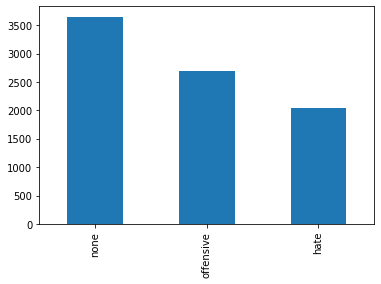

In [14]:
train_dev['label'].value_counts().plot(kind='bar')

In [15]:
print(train_dev.groupby('label').size().reset_index(name='count'))

       label  count
0       hate   2033
1       none   3646
2  offensive   2688


In [16]:
train_dev['comments']= train_dev['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글, 공백 제외한 후, 모두 제거

train_dev[:5]

,comments,label
0,현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,hate
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,none
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,hate
3,화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데,none
4,사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각이 없노,hate


In [17]:
test = test.reindex(columns = test.columns.tolist() + ["label"])

In [18]:
test['comments']= test['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글, 공백 제외한 후, 모두 제거

test[:5]

,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,NaN
1,둘다 넘 좋다행복하세요,NaN
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,NaN
3,원곡생각하나도 안나고 러블리즈 신곡나온줄 너무 예쁘게 잘봤어요,NaN
4,장현승 얘도 참 이젠 짠하다,NaN


In [19]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [20]:
okt = Okt()
okt.morphs('현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네', stem=True)


['현재',
 '호텔',
 '주인',
 '심정',
 '아',
 '난',
 '마른하늘',
 '에',
 '날벼락',
 '맞다',
 '호텔',
 '망하다',
 '생기다',
 '누',
 '군',
 '계속',
 '추모',
 '받다']

In [37]:
train_dev['tokenized'] = train_dev['comments'].apply(okt.morphs)
train_dev['tokenized'] = train_dev['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test['tokenized'] = test['comments'].apply(okt.morphs)
test['tokenized'] = test['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [22]:
# train_dev 데이터 토큰화
'''
x_train = []
for sentence in train_dev["comments"]:
  temp_x = okt.morphs(sentence, stem=True) #토큰화
  temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
  x_train.append(temp_x)
'''

In [23]:
print(x_train[:3])

[['현재', '호텔', '주인', '심정', '아', '난', '마른하늘', '날벼락', '맞다', '호텔', '망하다', '생기다', '누', '군', '계속', '추모', '받다'], ['한국', '적', '인', '미인', '대표', '적', '인', '분', '너무나', '곱', '고', '아름답다', '모습', '그', '모습', '뒤', '슬픔', '을', '미처', '알다', 'ㅠ'], ['못', '되다', '넘다', '들다', '남', '고통', '을', '즐기다', '넘다', '들이다', '젠', '마땅하다', '처벌', '을', '받다', '그', '래야', '공정하다', '사회', '지', '심다', '거두다']]


In [24]:
'''
# test 데이터 토큰화
x_test = []
for sentence in test["comments"]:
  temp_x = okt.morphs(sentence, stem=True) #토큰화
  temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
  x_test.append(temp_x)
'''

In [25]:
print(x_test[:3])

[['ㅋㅋㅋㅋ', '그래도', '조아하다', '팬', '많다', '좋다', 'ㅠㅠ', '니', '온유', '안', '만지다', '줌', 'ㅠㅠ'], ['두다', '넘다', '좋다', '행복하다'], ['근데', '만', '원', '이하', '현금', '결제', '만', '하라', '고', '써다', '집', '우리나라', '엄청', '많다']]


# 단어와 길이 분포 확인


In [199]:
'''
train_dev['label']
train_dev_mapping = pd.Series(['none','offensive','hate'])
label_new = {'none':0, 'offensive':1, 'hate':2}
print(train_dev_mapping.map(label_new))
train_dev_mapping
'''

"\ntrain_dev['label']\ntrain_dev_mapping = pd.Series(['none','offensive','hate'])\nlabel_new = {'none':0, 'offensive':1, 'hate':2}\nprint(train_dev_mapping.map(label_new))\ntrain_dev_mapping\n"

In [39]:
train_dev=train_dev.replace({"none":0,"offensive":1,"hate":2})
train_dev

,comments,label,tokenized
0,현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,2,"[현재, 호텔, 주인, 심정, 아, 난, 마른하늘, 날벼락, 맞고, 호텔, 망하게,..."
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,0,"[한국, 적, 인, 미인, 대표, 적, 인, 분, 너무나, 곱, 고, 아름다운, 모..."
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,2,"[못, 된, 넘, 남, 고통, 을, 즐겼던, 넘, 들이, 젠, 마땅한, 처벌, 을,..."
3,화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데,0,"[화, 어설펐는데, 화, 지나서부터는, 갈수록, 너무, 재밌던데]"
4,사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각이 없노,2,"[사람, 얼굴, 손톱, 긁은것은, 인격, 살해, 이고, 동영상, 몰카, 냐, 메걸,..."
...,...,...,...
466,지현우 범죄 저지르지 않았나요,1,"[지현우, 범죄, 저지르지, 않았나요]"
467,여자인생 망칠 일 있나 ㅋㅋ,2,"[여자, 인생, 망칠, 일, 있나, ㅋㅋ]"
468,근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는,1,"[근데, 전라도, 에서, 사고, 났는데, 굳이, 서울, 까지, 와서, 병원, 가느,..."
469,할매젖 뱃살 몸매 라인 유륜은 적당해야됨너무크거나 너무 작아도 엉덩이가 빵빵해야됨,2,"[할매, 젖, 뱃살, 몸매, 라인, 유륜, 적당해야, 됨, 너, 무크, 거나, 너무..."


In [36]:
'''
train_dev=train_dev.drop(columns=['tokenized'])
'''

KeyError: ignored

In [40]:
none_words = np.hstack(train_dev[train_dev.label == 0]['tokenized'].values)
offensive_words = np.hstack(train_dev[train_dev.label == 1]['tokenized'].values)
hate_words = np.hstack(train_dev[train_dev.label == 2]['tokenized'].values)

In [48]:
# Counter() 사용 단어 빈도수 카운트
none_words_count = Counter(none_words)
print(none_words_count.most_common(200))

[('을', 339), ('너무', 272), ('다', 259), ('사람', 237), ('만', 207), ('안', 201), ('진짜', 197), ('로', 190), ('에서', 190), ('왜', 189), ('하고', 165), ('씨', 156), ('못', 152), ('나', 145), ('연기', 144), ('더', 143), ('고', 136), ('인', 114), ('하는', 113), ('때', 112), ('요', 111), ('네', 110), ('ㅋㅋ', 109), ('드라마', 109), ('정말', 107), ('ㅠㅠ', 104), ('그', 101), ('면', 100), ('응원', 100), ('거', 99), ('인데', 97), ('게', 96), ('저', 94), ('적', 93), ('지', 93), ('님', 93), ('아', 91), ('말', 88), ('배우', 88), ('랑', 86), ('생각', 86), ('뭐', 83), ('넘', 83), ('분', 81), ('보고', 81), ('까지', 81), ('난', 79), ('ㅋ', 79), ('내', 78), ('합니다', 77), ('것', 76), ('ㅠ', 74), ('결혼', 74), ('좋은', 74), ('얼굴', 74), ('근데', 74), ('해', 73), ('그냥', 72), ('참', 71), ('이제', 70), ('기사', 69), ('많이', 69), ('하면', 67), ('ㅋㅋㅋ', 66), ('여자', 66), ('애', 65), ('할', 65), ('다시', 65), ('서', 64), ('라', 64), ('보다', 64), ('ㅜㅜ', 63), ('사랑', 62), ('ㅎㅎ', 60), ('엄마', 60), ('정도', 59), ('한테', 59), ('일', 57), ('중', 56), ('연예인', 56), ('방송', 56), ('이랑', 55), ('이다', 55), ('부터', 55), 

In [49]:
offensive_words_count = Counter(offensive_words)
print(offensive_words_count.most_common(200))

[('을', 264), ('다', 250), ('안', 244), ('사람', 214), ('여자', 200), ('왜', 188), ('로', 187), ('못', 173), ('만', 151), ('나', 150), ('지', 145), ('하고', 145), ('진짜', 137), ('고', 135), ('네', 135), ('ㅋㅋ', 133), ('뭐', 123), ('하는', 120), ('그', 118), ('너무', 115), ('남자', 107), ('더', 105), ('게', 102), ('애', 101), ('에서', 100), ('인데', 99), ('결혼', 99), ('그냥', 99), ('아', 98), ('때', 93), ('ㅋㅋㅋ', 93), ('돈', 91), ('니', 90), ('거', 89), ('기사', 86), ('야', 82), ('냐', 82), ('랑', 81), ('한테', 81), ('얼굴', 81), ('ㅋ', 80), ('저', 80), ('말', 79), ('라', 78), ('인', 78), ('연기', 75), ('서', 73), ('것', 72), ('드라마', 72), ('생각', 71), ('연예인', 71), ('면', 70), ('해', 65), ('하', 64), ('일', 63), ('이런', 63), ('까지', 62), ('이제', 62), ('할', 60), ('이나', 59), ('하나', 59), ('내', 59), ('방송', 58), ('적', 57), ('근데', 57), ('이다', 55), ('개', 55), ('누구', 54), ('부터', 54), ('댓글', 53), ('얘', 52), ('하지', 51), ('너', 51), ('년', 50), ('무슨', 50), ('씨', 50), ('많이', 49), ('참', 49), ('보고', 48), ('나이', 48), ('해서', 46), ('문제', 46), ('보다', 45), ('뭔', 45), ('욕', 45

In [50]:
hate_words_count = Counter(hate_words)
print(hate_words_count.most_common(200))

[('여자', 299), ('을', 214), ('다', 191), ('못', 176), ('남자', 170), ('안', 168), ('지', 163), ('ㅋㅋ', 153), ('만', 149), ('고', 146), ('로', 139), ('왜', 139), ('하고', 136), ('네', 131), ('아', 129), ('나', 128), ('니', 121), ('ㅋㅋㅋ', 121), ('사람', 117), ('애', 110), ('에서', 109), ('그', 103), ('진짜', 99), ('하는', 98), ('년', 96), ('라', 94), ('뭐', 93), ('저', 93), ('돈', 86), ('게', 84), ('때', 77), ('결혼', 76), ('개', 76), ('그냥', 74), ('또', 74), ('야', 73), ('할', 72), ('인', 71), ('하', 70), ('면', 69), ('말', 68), ('이나', 66), ('까지', 65), ('인데', 65), ('한테', 65), ('얼굴', 64), ('냐', 64), ('놈', 64), ('대', 62), ('연예인', 61), ('것', 60), ('쳐', 60), ('이다', 59), ('ㅋ', 58), ('ㅋㅋㅋㅋ', 58), ('적', 58), ('나이', 57), ('거', 57), ('한국', 56), ('더', 56), ('댓글', 55), ('일', 54), ('내', 53), ('서', 51), ('생각', 50), ('문', 50), ('한남', 49), ('살', 49), ('같은', 49), ('너', 49), ('드라마', 49), ('방송', 47), ('재앙', 47), ('랑', 47), ('보고', 46), ('해', 46), ('이런', 46), ('기사', 45), ('녀', 45), ('남', 44), ('뭔', 44), ('이네', 44), ('욕', 44), ('하나', 44), ('너무', 43), ('ㅉ

none의 평균 길이 : 10.92128359846407
offensive의 평균 길이 : 12.818824404761905
hate의 평균 길이 : 14.938022626660109


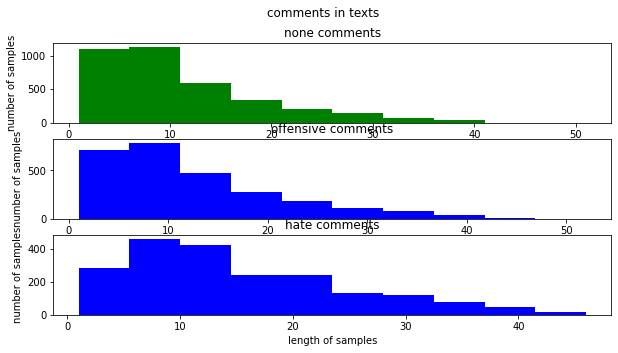

In [59]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1,figsize=(10,5))
fig.suptitle('comments in texts')
text_len = train_dev[train_dev['label']==0]['tokenized'].map(lambda x:len(x))
ax1.hist(text_len, color='green')
ax1.set_title('none comments')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('none의 평균 길이 :', np.mean(text_len))

text_len = train_dev[train_dev['label']==1]['tokenized'].map(lambda x:len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('offensive comments')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('offensive의 평균 길이 :', np.mean(text_len))

text_len = train_dev[train_dev['label']==2]['tokenized'].map(lambda x:len(x))
ax3.hist(text_len, color='blue')
ax3.set_title('hate comments')
ax3.set_xlabel('length of samples')
ax3.set_ylabel('number of samples')
print('hate의 평균 길이 :', np.mean(text_len))

In [114]:
X_train = train_dev['tokenized'].values
y_train = train_dev['label'].values
X_test= test['tokenized'].values
y_test = test['label'].values

# 정수 인코딩

In [115]:
tokenizer = Tokenizer()
# x_train 토큰화 수행
tokenizer.fit_on_texts(X_train) 

In [116]:
print(tokenizer.word_index)

{'을': 1, '다': 2, '안': 3, '사람': 4, '여자': 5, '로': 6, '왜': 7, '만': 8, '못': 9, '하고': 10, '진짜': 11, '너무': 12, '나': 13, '고': 14, '지': 15, '에서': 16, 'ㅋㅋ': 17, '네': 18, '남자': 19, '하는': 20, '그': 21, '아': 22, '더': 23, '뭐': 24, '때': 25, '게': 26, 'ㅋㅋㅋ': 27, '애': 28, '저': 29, '인': 30, '니': 31, '인데': 32, '결혼': 33, '그냥': 34, '거': 35, '씨': 36, '면': 37, '연기': 38, '라': 39, '말': 40, '드라마': 41, '얼굴': 42, '돈': 43, 'ㅋ': 44, '랑': 45, '적': 46, '것': 47, '까지': 48, '생각': 49, '한테': 50, '야': 51, '기사': 52, '할': 53, '년': 54, '내': 55, '서': 56, '연예인': 57, '해': 58, '요': 59, '냐': 60, '하': 61, '보고': 62, '일': 63, '이나': 64, '이제': 65, '이다': 66, '방송': 67, '근데': 68, 'ㅠㅠ': 69, '또': 70, '개': 71, '난': 72, '댓글': 73, '이런': 74, '정말': 75, '참': 76, '대': 77, '하면': 78, '하나': 79, '부터': 80, '많이': 81, '무슨': 82, '나이': 83, '님': 84, '같은': 85, '보다': 86, '정도': 87, '해서': 88, '응원': 89, '살': 90, '욕': 91, 'ㅋㅋㅋㅋ': 92, '임': 93, '너': 94, '배우': 95, '넘': 96, '하지': 97, '이랑': 98, '분': 99, '한국': 100, '이네': 101, '지금': 102, '뭔': 103, '놈': 104, '남': 105, '중'

In [117]:
# 케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,
# 케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에
# 배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 

vocab_size = len(tokenizer.word_index)+1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 22457


In [118]:
print(tokenizer.word_index)

{'을': 1, '다': 2, '안': 3, '사람': 4, '여자': 5, '로': 6, '왜': 7, '만': 8, '못': 9, '하고': 10, '진짜': 11, '너무': 12, '나': 13, '고': 14, '지': 15, '에서': 16, 'ㅋㅋ': 17, '네': 18, '남자': 19, '하는': 20, '그': 21, '아': 22, '더': 23, '뭐': 24, '때': 25, '게': 26, 'ㅋㅋㅋ': 27, '애': 28, '저': 29, '인': 30, '니': 31, '인데': 32, '결혼': 33, '그냥': 34, '거': 35, '씨': 36, '면': 37, '연기': 38, '라': 39, '말': 40, '드라마': 41, '얼굴': 42, '돈': 43, 'ㅋ': 44, '랑': 45, '적': 46, '것': 47, '까지': 48, '생각': 49, '한테': 50, '야': 51, '기사': 52, '할': 53, '년': 54, '내': 55, '서': 56, '연예인': 57, '해': 58, '요': 59, '냐': 60, '하': 61, '보고': 62, '일': 63, '이나': 64, '이제': 65, '이다': 66, '방송': 67, '근데': 68, 'ㅠㅠ': 69, '또': 70, '개': 71, '난': 72, '댓글': 73, '이런': 74, '정말': 75, '참': 76, '대': 77, '하면': 78, '하나': 79, '부터': 80, '많이': 81, '무슨': 82, '나이': 83, '님': 84, '같은': 85, '보다': 86, '정도': 87, '해서': 88, '응원': 89, '살': 90, '욕': 91, 'ㅋㅋㅋㅋ': 92, '임': 93, '너': 94, '배우': 95, '넘': 96, '하지': 97, '이랑': 98, '분': 99, '한국': 100, '이네': 101, '지금': 102, '뭔': 103, '놈': 104, '남': 105, '중'

In [119]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
# 케라스 토크나이저는 텍스트 시퀸스를 숫자 시퀸스로 변환하여 저장
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [120]:
print(X_train[:3])

[[1349, 1476, 3245, 2293, 22, 72, 8640, 5532, 1477, 1476, 3246, 2005, 935, 837, 213, 2294, 8641], [100, 46, 30, 1763, 791, 46, 30, 99, 2006, 1350, 14, 2007, 193, 21, 193, 380, 3247, 1, 8642, 8643, 1764, 107], [9, 230, 96, 105, 1617, 1, 8644, 96, 218, 404, 8645, 1099, 1, 5533, 21, 2684, 8646, 689, 15, 8647, 8648]]


In [121]:
print(X_test[:3])

[[92, 164, 117, 1199, 292, 69, 31, 8120, 3, 1491, 69], [309, 96, 664, 966], [68, 8, 170, 4072, 14217, 8, 1498, 14, 172, 498, 247, 734]]


In [123]:
#train_devdptj y_train과 y_test 별도 저장
y_train = np.array(train_dev['label'])
y_test = np.array(test['label'])

# 패딩

커멘트의 최대 길이 : 52
커멘트의 평균 길이 : 12.50687223616589


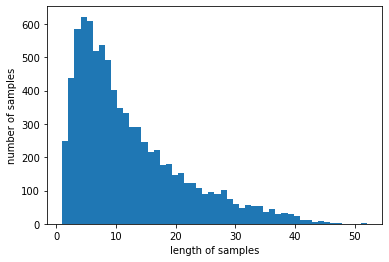

In [124]:
# X_train 패딩
print('커멘트의 최대 길이 :', max(len(l) for l in X_train))
print('커멘트의 평균 길이 :', sum(map(len, X_train))/len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

커멘트의 최대 길이 : 41
커멘트의 평균 길이 : 10.992813141683778


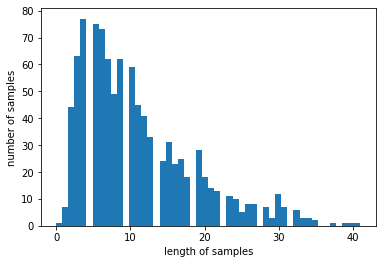

In [125]:
# X_test 패딩
print('커멘트의 최대 길이 :', max(len(l) for l in X_test))
print('커멘트의 평균 길이 :', sum(map(len, X_test))/len(X_test))

plt.hist([len(s) for s in X_test], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [127]:
# X_train과 X_test의 모든 샘플의 길이를 특정 길이로 맞춰줄 필요가 있음.
# 특정 길이 변수 : max_len으로 정함
# 대부분 커멘트의 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값 구하기.

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [128]:
max_len = 52
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 52 이하인 샘플의 비율: 100.0


In [129]:
# 샘플의 길이를 52로 맞춤.
max_len = 52
X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 커멘트 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 커멘트 패딩

# 레이블 값 분포

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


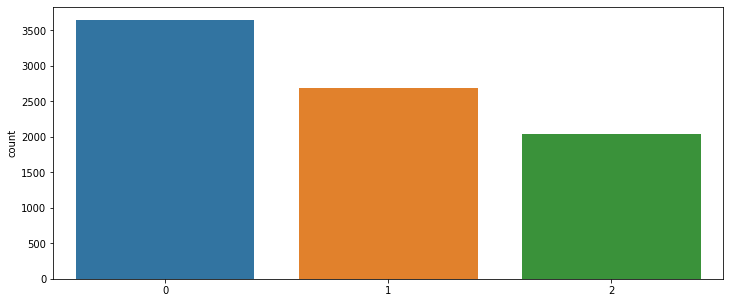

In [130]:
# 레이블 값의 분포
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)
sns.countplot(y_train)

In [131]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수 :")
print(np.asarray((unique_elements, counts_elements)))


각 레이블에 대한 빈도수 :
[[   0    1    2]
 [3646 2688 2033]]


In [180]:
y_train = to_categorical(y_train) # 훈련용 커멘트 레이블의 원_핫 인코딩
y_test = to_categorical(y_test) # 테스트용 커멘트의 원_핫 인코딩

In [152]:
# 3개 카테고리 분류 -> 출력층에서 3개의 뉴런사용
# 출력층의 활성화 함수 = 소프트맥스 함수 사용
# 소프트맥스 함수는 각 입력에 대해서 3개의 확률 분포를 만들어냄.
model = Sequential()
model.add(Embedding(vocab_size,100))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax')) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2245700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 2,363,335
Trainable params: 2,363,335
Non-trainable params: 0
_________________________________________________________________


In [134]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 
# 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping).
# 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다
# 좋아질 경우에만 모델을 저장.

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [160]:
# 모델 컴파일
# 이 경우 다중 클래스 분류(Multi-Class Classification) 문제이므로 
# 손실 함수로는 categorical_crossentropy를 사용
# categorical_crossentropy는 모델의 예측값과 실제값에 대해서 
# 두 확률 분포 사이의 거리를 최소화하도록 훈련.


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [161]:
# https://keras.io/ko/callbacks/
# 모델 학습
# validation_data로 X_test와 y_test사용
# val_loss 줄어들다가 증가하는 상황이 오면 과적합으로 판단하기 위함.
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=0, validation_data=(X_test, y_test), callbacks=[es,mc])

ValueError: ignored